<a id='introduction'></a>
## Introduction

---
The process is as follows:
1. [Explore the data](#explore_data)
    
    1.1 [Normal](#normal_case)
    
    1.2 [Pneumonia](#pneumonia_case)
    
    1.3 [COVID-19](#covid19_case)
    
    1.4 [CONCAT ALL DATA](#concat_pd) 
  
2. [The remaining problem](#remaining_problem)

---


The work follows (Lee, 2020), and divide the datasets (total: 6) into 3 classes by patient-level:

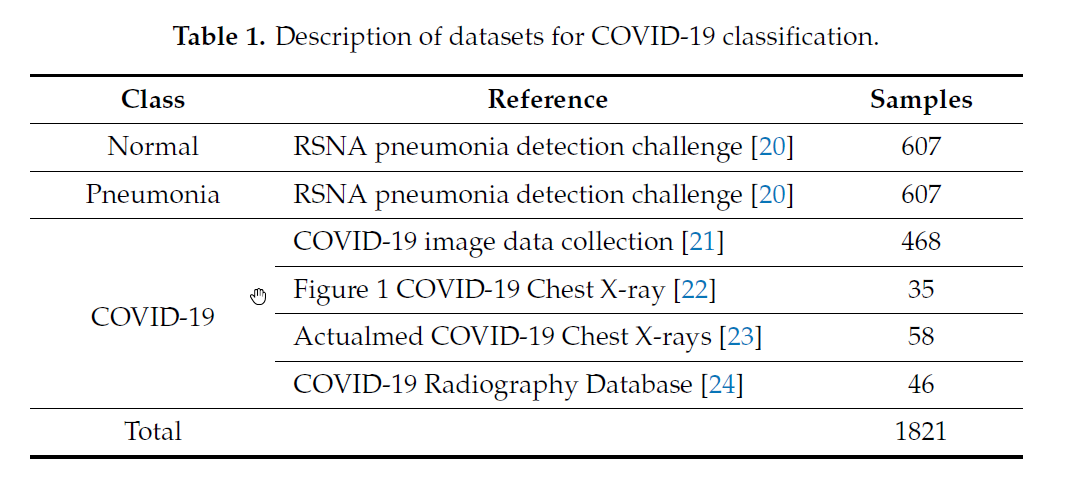


* Normal  (607)
    1. RSNA pneumonia detetion challenge
        *         No Lung Opacity / Not Normal    11821
        *         Lung Opacity                     9555
        *         Normal                           8851
  
* Pneumonia (**607** Deceased)
    1. RSNA pneumonia detetion challenge (Canceled)
    7. Chestx-ray8 (data)
    6. Chest X-Ray Images (chest-xray-pneumonia)

* COVID-19 (607)
    2. COVID-19 image data collection [2] (covid-chestxray-dataset) (468)
        * COVID
    3. Figure 1 COVID-19 Chest X-ray [3] (figure1covidchestxraydataset) (35)
        * COVID
    4. Actualmed COVID-19 Chest X-rays [4] (actualmedcovidchestxraydataset) (58)
        * COVID
    5. COVID-19 Radiography Database [5] (covid19-radiography-database) (46)
        * Normal
        * Lung Opacity
        * Viral Pneumonia


* unused datasets
    6. Chest X-Ray Images (chest-xray-pneumonia)
    7. Chestx-ray8 (data)

## Import Libraries

In [ ]:
import os
from pathlib import Path
from glob import glob

import random
import numpy as np
import pandas as pd

# import math
from imageio import imread
import pydicom as dcm
import cv2

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Path

In [ ]:
RSNA = "../input/rsna-pneumonia-detection-challenge"
CHEST_XARY_PNEUMONIA = "../input/chest-xray-pneumonia"
NIH_CHEST = "../input/data"

COVID19_COLLECTION = "../input/covid-chest-xray"
COVID19_FIG1 = "../input/figure1covidchestxraydataset"
COVID19_ACTUALMED = "../input/actualmedcovidchestxraydataset"
COVID19_RADIOGRAPHY = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"


<a id='explore_data'></a>
# 1. Explore the data

to divided the datasets at patient-level


![Data Processing Pipeline](https://i.ibb.co/311dStF/PA-AP-AP-ERECT.png)

<a id='normal_case'></a>
## 1.1 Normal

* RSNA [1]

* COVID-19 Radiography

*Note Chest-XRay-Pneumonia [6] can not divided on patient-level by Normal case*

### 1.1.1 RSNA

#### What are Lung Opacity?

is lung opacity equals pneumonia?
> I love this competition! But the title "Pneumonia Detection" for the competition is misleading because you actually have to do "Lung Opacities Detection", and **lung opacities are not the same as pneumonia**. Lung opacities are vague, fuzzy clouds of white in the darkness of the lungs, which makes detecting them a real challenge. [kernel](https://www.kaggle.com/zahaviguy/what-are-lung-opacities

Shows the difference between following two things:

**Normal vs. Lung Opacity images**
https://www.kaggle.com/zahaviguy/what-are-lung-opacities#Normal-vs.-Lung-Opacity-images

Currently, we will not use the `train_labels_df`, * Using the EDA pipeline of [RSNA Pneumonia Detection EDA](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda)

#### read csv file

In [ ]:
class_info_df = pd.read_csv(RSNA+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(RSNA+'/stage_2_train_labels.csv')
test_class_df = pd.read_csv(RSNA+'/stage_2_sample_submission.csv')
test_class_df = test_class_df.drop('PredictionString',1)

In [ ]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

In [ ]:
#Let's explore the two loaded files. We will take out a 5 rows samples from each dataset.
# class_info_df.sample(10)

In [ ]:
##using Path to load images

train_images = os.path.join(RSNA, 'stage_2_train_images')
test_images = os.path.join(RSNA, 'stage_2_test_images')


image_path_train= list(glob(train_images + '/*.dcm'))
image_path_test= list(glob(test_images + '/*.dcm'))

print("Number of images in train set:", len(image_path_train),
      "\nNumber of images in test set:", len(image_path_test))

> Only a reduced number of images are present in the training set (**26684**), compared with the number of images in the train_df data (**30227**). {`class_info_df.shape[0]`}

*It might be that we do have duplicated entries in the train and class datasets.* Let's check this.


#### check redundant meta data

In [ ]:
# train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

print(f"{train_labels_df.shape[0]} labels in train_labes_df in total, unique patientId in  train_labels_df: {train_labels_df['patientId'].nunique()}")

print(f"{class_info_df.shape[0]} labels in class_info_df in total, unique patientId in  class_info_df: {class_info_df['patientId'].nunique()}")

> We confirmed that the number of unique patientsId are equal with the number of DICOM images in the class_info set. What entries are duplicated. We want to check how are these distributed accross classes and Target value.

In [ ]:
tmp = class_info_df.groupby(['patientId', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Class', 'Entries']

# df2 = pd.concat([row_sum, df2], axis = 1)
df2.loc[7] = [df2['Exams'].sum(), 'NA', df2['Entries'].sum()]

df2

#### Map to filepath for each patient

The image in RSNA is the DICOM data, **The files names are the patients IDs**

Thanks to Kmada's [kernel](https://www.kaggle.com/portgasray/kmader-s-age-bone-with-am), we know how to extend a new column by mapping the filepath

In [ ]:
class_info_df['filepath'] = class_info_df['patientId'].map(lambda x: os.path.join(RSNA,
                                                         'stage_2_train_images', 
                                                         '{}.dcm'.format(x)))

In [ ]:
class_info_df.sample(10)

#### Sanity Check

In [ ]:
## check whether filepath is N/A
class_info_df[class_info_df['filepath'] == '']['patientId']

equals_num = 0
## check all the patientId equals to the filepath extracted Id
for i in range(class_info_df.shape[0]):
    example = class_info_df['filepath'].iloc[i]
    patientId = class_info_df['patientId'].iloc[i]
    extract_patientId = os.path.split(os.path.split(example)[1])[1].split('.')[0]
    if (extract_patientId == patientId):
        equals_num += 1

equals_num == class_info_df.shape[0]

In [ ]:
#we want to get the patient numbers
class_info_df['patientId'].unique().shape[0], train_labels_df['patientId'].unique().shape[0]

In [ ]:
# dist = all_data_df.target.map({0:'Target 0', 1:'Target 1'})
print(class_info_df['class'].value_counts(dropna=False))
dist = class_info_df['class'].value_counts()
fig = px.pie(dist,
             values='class',
             names=dist.index,
             hole=.4,title="Class Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
rsna_normal_df = class_info_df[class_info_df['class'] == 'Normal']
rsna_normal_df.shape[0], rsna_normal_df['patientId'].nunique()

#### DICOM meta data

In [ ]:
dicom_file_path = rsna_normal_df.iloc[1].filepath
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

* Patient sex;
* Patient age;
* Modality;
* Body part examined;
* View position;
* Rows & Columns;
* Pixel Spacing.

#### Display the DICOM images on Normal

In [ ]:
dcm.dcmread(rsna_normal_df.iloc[1].filepath).pixel_array.shape

In [ ]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

df = rsna_normal_df
#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    imagePath =  df.iloc[i].filepath
    data_row_img_data = dcm.read_file(imagePath)
    modality = data_row_img_data.Modality
    age = data_row_img_data.PatientAge
    sex = data_row_img_data.PatientSex
    data_row_img = dcm.dcmread(imagePath)
    
    plt.xlabel('ID: {}\nModality: {} Age: {} Sex: {}\nClass: {}'.format(
        df.iloc[i].patientId,
        modality, age, sex, df.iloc[i]['class']))
    plt.imshow(data_row_img.pixel_array, cmap='gray') #original: plt.cm.bone #optional: cmap='gray'
    plt.grid(False)
    
plt.show()

### 1.2.2 Normal on COVID-19 Radiography Database 

In [ ]:
## read csv
meta = pd.read_excel(COVID19_RADIOGRAPHY + '/Normal.metadata.xlsx')
meta.describe()
## image list
normal_images_path = list(glob(os.path.join(COVID19_RADIOGRAPHY, 'Normal', '*')))
if not len(normal_images_path) == meta.shape[0]:
    print(f'images number: {len(normal_images_path) } and meta shape size {meta.shape[0]}')

normal_images_regular = list(map(lambda x : os.path.split(x)[1].split('.')[0].upper(), normal_images_path))
print(f'the first 5 images from the normal folder: {normal_images_regular[:5]}')

##pin the image and path as the pandas dataframe
normal_image_path_map = pd.DataFrame({'FILE NAME': normal_images_regular, 'filepath': normal_images_path})

### sanity check
normal_image_path_map['FILE NAME'].isin(list(meta['FILE NAME']))

##merge with the meta dataframe
new_meta = pd.merge(meta, normal_image_path_map, on='FILE NAME', how='left')

##drop columns
new_meta.drop(['FORMAT', 'SIZE', 'URL'], axis = 1, inplace=True)

##rename the column
new_meta.rename(columns={"FILE NAME": "patientId"}, inplace = True)

In [ ]:
## put one in all
normal_covid10_radio_df = new_meta
normal_covid10_radio_df.shape[0]

<a id='pneumonia_case'></a>
## 1.2 Pneumonia

* Chest-XRay-Pneumonia [6] **Note this datasets only divided on patient-level by Pneumonia case**
* ChestX-ray8 (**data**)

---

**Ouput Patient**

1. chest_xray_pneumonia_df: 1674
2. ChestX_ray_pneumonia_df: 285

### 1.2.1 Chest-Xray only for Pneumonia

There's no patient level on normal case


* maybe create the *csv file* by `Path` follows the [kernel](https://www.kaggle.com/portgasray/cnn-x-ray-98-test-set-addressing-class-imbalance)


In [ ]:
# CHEST_XARY_PNEUMONIA

base_dir = os.path.join(CHEST_XARY_PNEUMONIA, 'chest_xray')

train_dir= Path(base_dir + '/train')
test_dir = Path(base_dir + '/test')
val_dir  = Path(base_dir + '/val')


In [ ]:
#create the lists of filespaths from the 3 directories: train,test and val
files_path_train= list(train_dir.glob(r'*/*.jpeg'))
files_path_test= list(test_dir.glob(r'*/*.jpeg'))
files_path_val = list(val_dir.glob(r'*/*.jpeg'))


In [ ]:
#create the lists of lables for each filepath
labels_train= list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_train)) 
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_test))
labels_val= list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_val))

In [ ]:
print(files_path_train[0])

x = files_path_train[0]
os.path.split(os.path.split(x)[1])[1].split('.')[0]

In [ ]:
## create the lists of patient id for each filepath
patient_train = list(map(lambda x: os.path.split(os.path.split(x)[1])[1].split('.')[0], files_path_train)) 
patient_test = list(map(lambda x: os.path.split(os.path.split(x)[1])[1].split('.')[0], files_path_test)) 
patient_val = list(map(lambda x: os.path.split(os.path.split(x)[1])[1].split('.')[0], files_path_val)) 

In [ ]:
#create the columns for the dataframes
patient_train = pd.Series(patient_train, name= 'patientId')
patient_test = pd.Series(patient_test, name= 'patientId')
patient_val = pd.Series(patient_val, name= 'patientId')

labels_train= pd.Series(labels_train, name= 'class')
labels_test= pd.Series(labels_test, name= 'class')
labels_val = pd.Series(labels_val, name= 'class')

images_train= pd.Series(files_path_train, name= 'filepath').astype(str)
images_test = pd.Series(files_path_test, name= 'filepath').astype(str)
images_val = pd.Series(files_path_val, name= 'filepath').astype(str)

#create the dataframes
train_df= pd.concat([patient_train, labels_train, images_train], axis=1)
test_df = pd.concat([patient_test, labels_test, images_test], axis=1)
val_df= pd.concat([patient_val, labels_val, images_val], axis=1)

# train_df[train_df['target']=='NORMAL'].head(10)
train_df.shape[0], test_df.shape[0], val_df.shape[0]

In [ ]:
## distribution of test train and val
fig = px.bar([train_df.shape[0], val_df.shape[0], test_df.shape[0]],
             x = ['train', 'val', 'test'],
             y = [train_df.shape[0], val_df.shape[0], test_df.shape[0]],
             barmode="group",
             title="Train Distribution")
fig.show()

In [ ]:
#concat to one dataframe
CHEST_XARY_PNEUMONIA
chest_xray_df = pd.concat([train_df, test_df, val_df])

##sanity check
chest_xray_df.shape[0] == train_df.shape[0] + test_df.shape[0] + val_df.shape[0], chest_xray_df.shape[0] 

In [ ]:
# dist = all_data_df.target.map({0:'Target 0', 1:'Target 1'})
dist = chest_xray_df['class'].value_counts(dropna=False)
fig = px.pie(dist,
             values='class',
             names=dist.index,
             hole=.4,title="Class Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
## selected data for pneumonia case
chest_xray_pneumonia_df = chest_xray_df[chest_xray_df["class"] =="PNEUMONIA"]

In [ ]:
chest_xray_pneumonia_df['patientId'] = chest_xray_pneumonia_df['patientId'].map(lambda x: os.path.split(os.path.split(x)[1])[1].split('_')[0].replace('person',''))
chest_xray_pneumonia_df.sample(5)

In [ ]:
chest_xray_pneumonia_df['patientId'].nunique() == chest_xray_pneumonia_df.shape[0]

print(f"{chest_xray_pneumonia_df.shape[0]} rows in chest_xray_pneumonia_df in total, unique patientId in chest_xray_pneumonia_df: {chest_xray_pneumonia_df['patientId'].nunique()}")

#### Display the Chest-Xray images on Pneumonia

In [ ]:
imread(chest_xray_pneumonia_df.iloc[1].filepath).shape

In [ ]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

df = chest_xray_pneumonia_df

#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    
    #get the path from dataframe
    imagePath =  df.iloc[i].filepath
    #read from path
    img = imread(imagePath)
    
    plt.xlabel('ID: {}\n Class: {}'.format(
        df.iloc[i].patientId,
        df.iloc[i]['class']))
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    
plt.show()

### 1.2.2 Chestx-ray8

Thanks to the following kernels:

1. [ChestX-ray8 [EDA, Beginner Code]](https://www.kaggle.com/mohamed3abdelrazik/chestx-ray8-eda-beginner-code)

2. [NIH EDA](https://www.kaggle.com/tejasharitsavk/nih-eda)


> There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

* Atelectasis
* Consolidation
* Infiltration
* Pneumothorax
* Edema
* Emphysema
* Fibrosis
* Effusion
* Pneumonia
* Pleural_thickening
* Cardiomegaly
* Nodule Mass
* Hernia

In [ ]:
ChestXray_DATAFRAME  = "../input/chestxray8-dataframe"

##All images by glob
image_path = list(glob(NIH_CHEST+'/images_*/images/*.png'))

#the official csv file
ChestX_ray8_df = pd.read_csv(NIH_CHEST + "/Data_Entry_2017.csv")

#the third party csv file 
ChestXray8_dataframe_df = pd.read_csv(os.path.join(ChestXray_DATAFRAME, 'train_df.csv'))
#the discussed bad labels, which need to be removed
ChestXray8_bad_labels_df = pd.read_csv(os.path.join(ChestXray_DATAFRAME, 'cxr14_bad_labels.csv'))

print('the original ChestXray8')
ChestX_ray8_df.sample(10)

In [ ]:
ChestXray8_dataframe_df.head(5)

In [ ]:
print(f"Number for images found in data folder: {len(image_path)},\n \
      labels in ChestX-ray8: {ChestX_ray8_df.shape[0]},\n \
      ChestXray8_dataframe_df: {ChestXray8_dataframe_df.shape[0]}, \n \
      All bad labels in ChestXray8: {ChestXray8_bad_labels_df.shape[0]}, \n \
      the unique patient number in ChestXray8_dataframe_df: {ChestXray8_dataframe_df['Patient ID'].nunique()}, \n \
      the unique patient number in ChestX_ray8_df {ChestX_ray8_df['Patient ID'].nunique()}")

In [ ]:
# all classes of ChestX-ray8 and the Pneumonia case
print(f"the total labels in ChectX-ray8: {len(ChestX_ray8_df['Finding Labels'].unique())}, \
      the unique labels in ChestX_ray8: {ChestX_ray8_df[ChestX_ray8_df['Finding Labels'] == 'Pneumonia'].shape[0]}")

In [ ]:
##EDA
print(ChestX_ray8_df['Finding Labels'].value_counts(dropna=False))
# dist = ChestX_ray8_df['finding'].value_counts(dropna=False)
# fig = px.pie(dist,
#              values='finding',
#              names=dist.index,
#              hole=.4,title="Finding Distribution")
# fig.update_traces(textinfo='percent+label', pull=0.05)
# fig.show()


#### preprocessing the ChestXray8

* remove the unused column 'Unnamed: 11'
* add new column as 'class'
* drop the 'No Finding' column in the ChestXray8_dataframe_df (**chestxray8-dataframe**)
* rename some columns as below in **ChestX_ray8_df** (data) & **ChestXray8_dataframe_df** (chestxray8-dataframe)
    * Image Index --> Index
    * Patient ID --> patientId
* remove the bad labels in **ChestX_ray8_df** corresponding to **ChestXray8_bad_labels_df**

In [ ]:
ChestX_ray8_df.drop(columns=["Unnamed: 11"], inplace=True)
# ChestX_ray8_df["class"] = ChestX_ray8_df["Finding Labels"].apply(lambda x: x.split("|"))

ChestXray8_dataframe_df.drop(['No Finding'], axis = 1, inplace = True)

ChestX_ray8_df.rename(columns={"Image Index": "Index"}, inplace = True)
ChestX_ray8_df.rename(columns={"Patient ID": "patientId"}, inplace = True)
ChestX_ray8_df.rename(columns={"Finding Labels": "class"}, inplace = True )

> You oboserve that in main datasetData_Entry_2017.csv contains 112120 rows but in modified dataset train_df.csv contains only 111863 images. It turns out some of the images are problematic as discussed in this datasets discussion [thread](https://www.kaggle.com/nih-chest-xrays/data/discussion/55461). They are inverted, not-frontal or somehow badly rotated. Therefore they are removed. So we need to do a little bit of peprocessing here to deal with that matter and we are good to go.

In [ ]:
ChestXray8_bad_labels_df.head(5)

In [ ]:
ChestX_ray8_df = ChestX_ray8_df[~ChestX_ray8_df.Index.isin(ChestXray8_bad_labels_df.Index)]

ChestX_ray8_df.shape[0]

In [ ]:
ChestX_ray8_df.sample(5)

#### Map the filepath to csv image index

In [ ]:
index_path_map = pd.DataFrame({'Index':list(map(lambda x:os.path.split(x)[1], image_path)), 'filepath': image_path})
index_path_map.head()

In [ ]:
# Merge the absolute path of the images to the main dataframe
ChestXray8_df = pd.merge(ChestX_ray8_df, index_path_map, on='Index', how='left')

In [ ]:
labels = ["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema", "Emphysema", "Fibrosis", "Effusion", "Pneumonia",
"Pleural_thickening", "Cardiomegaly", "Nodule Mass", "Hernia", "No Finding"]
print(labels)

In [ ]:
print (ChestXray8_df.columns), ChestXray8_df.iloc[1]['class']

In [ ]:
#contains the pneumonia case
ChestX_ray_pneumonia_df = ChestXray8_df[ChestXray8_df['class'].map(lambda x: 'Pneumonia' in x)]
ChestX_ray_pneumonia_df.shape[0]

In [ ]:
ChestX_ray_pneumonia_df['class'].nunique(), ChestX_ray_pneumonia_df['patientId'].nunique()

In [ ]:
#only the pneumonia case
ChestXray8_pneumonia_df = ChestXray8_df[ChestXray8_df['class'] == 'Pneumonia']

ChestXray8_pneumonia_df.shape[0], ChestXray8_pneumonia_df['patientId'].nunique()

In [ ]:
ChestXray8_pneumonia_df = ChestXray8_pneumonia_df[['patientId', 'filepath', 'class']]

In [ ]:
ChestXray8_pneumonia_df.head(5)

#### Display the ChestX-ray8 images on Pneumonia

In [ ]:
imread(ChestXray8_pneumonia_df.iloc[1].filepath).shape

In [ ]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

df = ChestXray8_pneumonia_df

#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    
    #get the path from dataframe
    imagePath =  df.iloc[i].filepath
    #read from path
    img = imread(imagePath)
    
    plt.xlabel('ID: {}\n Class: {}'.format(
        df.iloc[i].patientId,
        df.iloc[i]['class']))
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    
plt.show()

<a id='covid19_case'></a>
## 1.3 COVID-19

* COVID-19 (607)
    2. COVID-19 image data collection [2] (covid-chest-xray) (468)
    3. Figure 1 COVID-19 Chest X-ray [3] (figure1covidchestxraydataset) (35)
    4. Actualmed COVID-19 Chest X-rays [4] (actualmedcovidchestxraydataset) (58)
    5. COVID-19 Radiography Database [5] (covid19-radiography-database) (46)
    
#### Questions

1. Shall filter out no-**PA** view?

![PA_AP_AP-ERECT](https://i.ibb.co/zPzThC7/Data-Processing-Pipeline-2x.png)

### 1.3.1 COVID-19 image data collection

Thanks to the kernel [Lungs X-ray Class COVID-Pneumonia](https://www.kaggle.com/jcastanonv/lungs-x-ray-class-covid-pneumonia)

* Remove the error raw without name in the image folder
* Filtering the `finding` and `view`


In [ ]:
print(COVID19_COLLECTION)

# ext = ['png', 'jpg', 'gif', 'jpeg', 'JPG', 'PNG', 'JPG', 'GIF']    # Add image formats here
# new = []
# [new.extend(glob(COVID19_COLLECTION + '/images/' + '*.' +  e)) for e in ext]

covid19_collection_images_path = list(glob(COVID19_COLLECTION +'/images/*'))
covid19_collection_images = list(map(lambda x : os.path.split(x)[1], covid19_collection_images_path))
len(covid19_collection_images_path), covid19_collection_images_path[1]

# list(set(covid19_collection_images_path) -  set(new))

# len(set(new))
# new[:1],  covid19_collection_images_path[:1]

In [ ]:
meta = pd.read_csv(os.path.join(COVID19_COLLECTION, 'metadata.csv'))
meta.shape[0]

#### EDA of COVID-19 Collection

In [ ]:
fig = px.bar(meta['finding'].value_counts(),
             x = list(meta['finding'].unique()),
             y = meta['finding'].value_counts(),
             barmode="group",
             title="Finding Distribution")
fig.show()

In [ ]:
meta.sample(5)

In [ ]:
print(list(meta.columns))
# meta[['patientid','view', 'finding', 'filename']].sample(5)

#### Filtering

**WHY PA?**

1. research the kernel: [COVID-19 detection with Heat-map visualization](https://www.kaggle.com/basu369victor/covid-19-detection-with-heat-map-visualization) 
> we, are going to train our model against the only "PA" view of the lungs X-ray images.



In [ ]:
meta['view'].value_counts(dropna=False)

In [ ]:
## remove the the data not in images folder
new_meta = meta[meta['filename'].isin(covid19_collection_images)]

#sanity check
exist_num = 0
## check all the patientId equals to the filepath extracted Id
for i in range(meta.shape[0]):
    example = meta['filename'].iloc[i]
    if example in covid19_collection_images:
        exist_num += 1

exist_num == new_meta.shape[0]

# for x in new_meta['filename']:
#     if x.split('.')[-1]=='gz':
#         print('1')

In [ ]:
## select the finding == 'COVID-19' && view = 'PA'
new_meta = new_meta[(new_meta['finding'] == 'COVID-19') & (new_meta['view'] == 'PA')]
new_meta.shape[0]

After remove the unused row, which do not exist path in the images folder, and filtering `finding == 'COVID-19'` and `view == 'PA'`, we get the number of useful data **141** compare to the original **372**

#### rename the dataframe with selected columns

In [ ]:
new_meta = new_meta[['patientid', 'finding', 'filename']]

new_meta.rename(columns={"patientid": "patientId"}, inplace = True)
new_meta.rename(columns={"finding": "class"}, inplace = True)

##map filename to filepath
new_meta['filepath'] = new_meta['filename'].map(lambda x: os.path.join(COVID19_COLLECTION, 'images', x))
new_meta.drop(['filename'], axis = 1, inplace = True)

print(new_meta['filepath'].iloc[0])
new_meta.head(5)

In [ ]:
covid_chest_xray_df = new_meta
covid_chest_xray_df.shape[0]

#### Display the images

In [ ]:
imread(covid_chest_xray_df.iloc[1].filepath).shape

In [ ]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

df = covid_chest_xray_df

#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    
    #get the path from dataframe
    imagePath =  df.iloc[i].filepath
    #read from path
    img = imread(imagePath)
    
    plt.xlabel('ID: {}\n Class: {}'.format(
        df.iloc[i].patientId,
        df.iloc[i]['class']))
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    
plt.show()

### 1.3.2 Figure 1 COVID-19 Chest X-ray [3]

* corresponding to `figure1covidchestxraydataset`

1. read csv file
2. EDA the data
3. remove non-exist meta data
4. rename the column name
5. map patientId to filepath
6. Info image shape
7. display the images


In [ ]:
## read csv file
COVID19_FIG1 = "../input/figure1covidchestxraydataset"
meta = pd.read_csv(os.path.join(COVID19_FIG1, 'metadata.csv'))

print(meta.shape[0])
meta.head(5)

#### EDA

In [ ]:
dist = meta['finding'].value_counts(dropna=False)
fig = px.pie(dist,
             values='finding',
             names=dist.index,
             hole=.4,title="Finding Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
print(meta['view'].value_counts(dropna=False))
dist = meta['view'].value_counts(dropna=False)
fig = px.pie(dist,
             values='view',
             names=dist.index,
             hole=.4,title="View Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
## images path 
images_path = list(glob(COVID19_FIG1 + '/images/*'))
## images extracted from images path
image2patientId = list(map(lambda x: os.path.split(x)[1].split('.')[0], images_path))

##create a pd for image & image path
patientId_filepath_map = pd.DataFrame({'patientid': image2patientId, 'filepath': images_path})
patientId_filepath_map.head(5)

In [ ]:
## map the patientId to filepath
meta = pd.merge(meta, patientId_filepath_map, on='patientid', how='left')

## filtering out non `covid-19` and `PA` view data
meta = meta[(meta['finding'] == 'COVID-19') & (meta['view'] == 'PA')]

In [ ]:
## rename the columns
meta.rename(columns={"patientid": "patientId"}, inplace = True)
meta.rename(columns={"finding": "class"}, inplace = True)

In [ ]:
### selected columns
meta = meta[['patientId', 'class', 'filepath']]

In [ ]:
fig1_covid19_df = meta
fig1_covid19_df.shape[0]

### Display the images on Fig1

In [ ]:
df = fig1_covid19_df
num_rows = 1
num_cols = 2

#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    
    #get the path from dataframe
    imagePath =  df.iloc[i].filepath
    #read from path
    img = imread(imagePath)
    
    plt.xlabel('ID: {}\n Class: {}'.format(
        df.iloc[i].patientId,
        df.iloc[i]['class']))
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    
plt.show()

### 1.3.3 Actualmed COVID-19 Chest X-rays
    4. Actualmed COVID-19 Chest X-rays [4] (actualmedcovidchestxraydataset) (58)

#### read csv file

In [ ]:
COVID19_ACTUALMED = "../input/actualmedcovidchestxraydataset"
meta = pd.read_csv(os.path.join(COVID19_ACTUALMED, 'metadata.csv'))
print(meta.shape[0], list(meta.columns))

meta.head(5)
# meta.iloc[1].imagename

#### EDA

In [ ]:
print(meta['view'].value_counts(dropna=False))
dist = meta['view'].value_counts(dropna=False)
fig = px.pie(dist,
             values='view',
             names=dist.index,
             hole=.4,title="View Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
print(meta['finding'].value_counts(dropna=False))
dist = meta['finding'].value_counts(dropna=False)
fig = px.pie(dist,
             values='finding',
             names=dist.index,
             hole=.4,title="Finding Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

#### Mapping

In [ ]:
## image path
COVID19_ACTUALMED
actualmed_image_paths = list(glob(COVID19_ACTUALMED + '/images/*'))

## image list
actualmed_images = list(map(lambda x: os.path.split(x)[1] , actualmed_image_paths))
len(actualmed_image_paths), actualmed_image_paths[1], actualmed_images[1]

##create a pd for imagename & image path
imagename_filepath_map = pd.DataFrame({'imagename': actualmed_images, 'filepath': actualmed_image_paths})
print(imagename_filepath_map.shape[0] == meta.shape[0], imagename_filepath_map.shape[0])
imagename_filepath_map.head(5)

In [ ]:
## map imagename with filepath
meta = pd.merge(meta, imagename_filepath_map, on='imagename', how='left')

#### Filtering

In [ ]:
## select: finding equals COVID-19, view equals PA
meta = meta[(meta['finding'] == 'COVID-19') & (meta['view'] == 'PA') ]
## only three columns
meta = meta[['patientid', 'finding', 'filepath']]

#### rename

In [ ]:
## rename the columns
meta.rename(columns={"patientid": "patientId"}, inplace = True)
meta.rename(columns={"finding": "class"}, inplace = True)

In [ ]:
actualmed_covid_df = meta
actualmed_covid_df.shape[0]

#### Display the images on Actualmed Covid-19

In [ ]:
df = actualmed_covid_df
num_rows = 4
num_cols = 4

#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    
    #get the path from dataframe
    imagePath =  df.iloc[i].filepath
    #read from path
    img = imread(imagePath)
    
    plt.xlabel('ID: {}\n Class: {}'.format(
        df.iloc[i].patientId,
        df.iloc[i]['class']))
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    
plt.show()

### 1.3.4 COVID-19 Radiography Database

    5. COVID-19 Radiography Database [5] (covid19-radiography-database) (46)
    # COVID19_RADIOGRAPHY = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

In [ ]:
!pip install openpyxl
!pip install xlrd

In [ ]:
#read csv file
meta = pd.read_excel(os.path.join(COVID19_RADIOGRAPHY, 'COVID.metadata.xlsx'))
print(meta.shape[0])
meta.sample(10)

In [ ]:
#QUICK EAD - NO NEED

In [ ]:
## Mapping 
## image path
image_paths = list(glob(COVID19_RADIOGRAPHY + '/COVID/*'))
## image list
images_name = list(map(lambda x: os.path.split(x)[1].split('.')[0], image_paths))

## create a pd for imagename & image path
image_filepath_map = pd.DataFrame({'FILE NAME': images_name, 'filepath': image_paths})
print(image_filepath_map.shape[0] == meta.shape[0], image_filepath_map.shape[0])
meta = pd.merge(meta, image_filepath_map, on='FILE NAME', how='left')
meta.head(5)

In [ ]:
## only three columns
meta = meta[['FILE NAME', 'filepath']]
## rename the columns
meta.rename(columns={"FILE NAME": "patientId"}, inplace = True)
## adding new column
meta['class'] = 'COVID-19'

In [ ]:
covid19_radiography_df = meta

In [ ]:
df = covid19_radiography_df
num_rows = 4
num_cols = 4

#subplot the figures from test data
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    
    #get the path from dataframe
    imagePath =  df.iloc[i].filepath
    #read from path
    img = imread(imagePath)
    
    plt.xlabel('ID: {}\n Class: {}'.format(
        df.iloc[i].patientId,
        df.iloc[i]['class']))
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    
plt.show()

<a id='concat_pd'></a>
### 1.4 COMBINE A FULL PD

* rsna_normal_df
* chest_xray_pneumonia_df
* ChestXray8_pneumonia_df
* covid_chest_xray_df
* fig1_covid19_df
* actualmed_covid_df
* covid19_radiography_df

#### Fine-tune
1. normal --> NORMAL (RSNA)
2. Pneumonia --> PNEUMONIA (ChestX-ray8)

In [ ]:
#Normal to NORMAL
rsna_normal_df.drop(['class'], axis = 1, inplace=True)
rsna_normal_df['class'] = 'NORMAL'
normal_covid10_radio_df['class'] = 'NORMAL'

In [ ]:
# Pneumonia to PNEUMONIA
ChestXray8_pneumonia_df.drop(['class'], axis = 1, inplace=True)
ChestXray8_pneumonia_df['class'] = 'PNEUMONIA'

chest_xray_pneumonia_df.head(5), ChestXray8_pneumonia_df.head(5)

In [ ]:
#COVID-19
covid_chest_xray_df.head(5)

In [ ]:
fig1_covid19_df.head(5)

In [ ]:
actualmed_covid_df.head(5)

In [ ]:
covid19_radiography_df.head(5)

### CONCAT

In [ ]:
pneumonia_df = pd.concat([chest_xray_pneumonia_df, ChestXray8_pneumonia_df])

covid19_df = pd.concat([covid_chest_xray_df, fig1_covid19_df, actualmed_covid_df, covid19_radiography_df])

##due to the dic is not same as other format
all_df = pd.concat([normal_covid10_radio_df,
                   pneumonia_df,
                   covid19_df])
all_df.shape[0]

In [ ]:
print(all_df['class'].value_counts())
dist = all_df['class'].value_counts()
fig = px.pie(dist,
             values='class',
             names=dist.index,
             hole=.4,title="Class Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

In [ ]:
all_df.to_csv('normal_covid19_pneumonia.csv')

<a id='remaining_problem'></a>
# 2. Remaining Problem

Coming:



Finished:

* DICM combine with other format of JPG, PNG, JPEG.
* Check any filepath or column is null
* NORMAL CASE can be replaced by the dataset **COVID-19 Radiography databse**

In [ ]:
all_df.isnull().values.any()


all_df['filepath'].isna().any()

## 

# Reference

[1] Radiological Society of North America. RSNA Pneumonia Detection Challenge; Radiological Society of North America: Oak Brook, IL, USA, 2018

[2] Cohen, J.P.; Morrison, P.; Dao, L. COVID-19 image data collection. arXiv 2020, arXiv:2003.11597. Available online: https://github.com/ieee8023/covid-chestxray-dataset

[3] Chung, A. Figure 1 COVID-19 Chest X-ray Data Initiative. 2020. Available online: https://github.com/agchung/Figure1-COVID-chestxray-dataset (accessed on 4 May 2020).

[4] Chung, A. Actualmed COVID-19 Chest X-ray Data Initiative. 2020. Available online: https://github.com/agchung/Actualmed-COVID-chestxray-dataset (accessed on 6 May 2020).

[5] Rahman, T.; Chowdhury, M.; Khandakar, A. COVID-19 Radiography Database; Kaggle: San Francisco, CA, USA, 2020.

[6] Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2 Available online: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

[7] Wang, X., Peng, Y., Lu, L., Lu, Z., Bagheri, M. and Summers, R. M., “Chestx-ray8: Hospital-scale chest x-ray database and benchmarks on weakly-supervised classification and localization of common thorax diseases,” Proc. IEEE Conf. Comput. Vis. pattern Recognit., 2097–2106 (2017). Available online: https://www.kaggle.com/nih-chest-xrays/data